# Text to Text Explanation: Open Ended Text Generation Using GPT2

This notebook demonstrates how to get explanations for the output of gpt2 used for open ended text generation. In this demo, we use the pretrained gpt2 model provided by hugging face (https://huggingface.co/gpt2) to explain the generated text by gpt2. We further showcase how to get explanations for custom output generated text and plot global input token importances for any output generated token.

In [1]:
import numpy as np
from transformers import AutoTokenizer, AutoModelForCausalLM
import shap
import torch

### Load model and tokenizer

In [2]:
tokenizer = AutoTokenizer.from_pretrained("gpt2", use_fast=True)
model =  AutoModelForCausalLM.from_pretrained("gpt2").cuda()

Below, we set certain model configurations. We need to define if the model is a decoder or encoder-decoder.
This can be set through the 'is_decoder' or 'is_encoder_decoder' param in model's config file.
We can also set custom model generation parameters which will be used during the output text generation decoding process.

In [3]:
# set model decoder to true and generation params
model.config.is_decoder=True
model.config.text_generation_params = {
    "do_sample": True,
    "max_length": 50,
    "temperature": 0.7,
    "top_k": 0
  }

### Define initial text

In [4]:
s=["I enjoy walking with my cute dog"]

### Create an explainer object

In [5]:
explainer = shap.Explainer(model,tokenizer)

explainers.Partition is still in an alpha state, so use with caution...


### Compute shap values

In [6]:
shap_values = explainer(s)

Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


### Visualize shap explanations

In [7]:
shap.plots.text(shap_values)

,I,enjoy,walking,with,my,cute,dog
",",-0.117,-0.431,-0.427,0.072,-0.15,-0.238,4.064
but,0.873,1.015,-0.029,0.311,-0.112,0.378,-0.781
I,1.005,0.023,-0.002,-0.107,0.405,-0.16,0.016
also,0.744,1.158,-0.172,0.27,0.01,0.132,0.084
like,0.116,1.857,-0.365,0.12,-0.373,0.516,0.081
taking,0.167,0.463,0.842,0.178,0.189,-0.249,0.005
my,0.018,0.205,0.028,-0.093,0.283,-0.019,0.316
kids,0.806,0.044,0.185,0.256,-0.148,-0.173,0.385
to,0.095,0.151,-0.018,-0.023,-0.103,0.133,0.126
the,0.018,-0.043,0.238,-0.114,0.132,0.017,0.128


### Another example...

In [8]:
s=['Scientists confirmed the worst possible outcome: the massive asteroid will collide with Earth']

In [9]:
explainer = shap.Explainer(model,tokenizer)

explainers.Partition is still in an alpha state, so use with caution...


In [10]:
shap_values = explainer(s)

Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


In [11]:
shap.plots.text(shap_values)

,Scientists confirmed the worst,possible outcome,: the,massive asteroid,will,collide,with,Earth
in,0.478,-0.323,-0.507,0.314,0.308,0.806,0.489,1.436
2015,1.226,0.134,-0.273,0.14,0.485,1.149,-0.742,0.841
.,0.1,-0.059,0.013,0.131,-0.006,0.758,0.79,-0.336
,0.431,0.402,0.158,0.096,-0.01,0.016,0.233,-0.121
,0.98,0.679,-0.653,0.045,-0.026,0.17,0.359,0.006
"""",0.633,0.23,-0.146,-0.009,-0.052,-0.094,0.118,-0.126
We,0.216,0.078,-0.044,-0.1,0.013,0.02,0.06,0.057
believe,0.29,0.081,0.068,0.034,0.103,0.138,0.103,-0.043
there,0.217,0.066,-0.006,0.003,-0.03,-0.036,-0.035,-0.089
is,-0.224,0.157,0.061,-0.009,0.011,-0.01,-0.009,0.116


##  Custom text generation and debugging biased outputs

Below we demonstrate the process of how to explain the liklihood of generating a particular output sentence given an input sentence using the model. <br><br>
For example, we ask a question:<br>
Which country's inhabitant (target) in the sentence "I know many people who are [<b>target</b>]." would have a high liklilhood of generating the token "vodka" in the output sentence "They love their <b>vodka</b>!" ?
<br><br>
For this, we first define input-output sentence pairs

In [12]:
biased_sentence_pairs = {
    "I know many people who are Russian." : "They love their vodka!",
    "I know many people who are Greek." : "They love their vodka!",
    "I know many people who are Australian." : "They love their vodka!",
    "I know many people who are American." : "They love their vodka!",
    "I know many people who are Italian." : "They love their vodka!",
    "I know many people who are Spanish." : "They love their vodka!",
    "I know many people who are German." : "They love their vodka!",
    "I know many people who are Indian." : "They love their vodka!"
}

Next we define a custom text generation function which returns the target sentence ids of the output sentence of choice to be generated by the model. 

In [13]:
def generate_biased_output(x):
    # we get the target sentence by a dictionary lookup from the previously defined sentence pairs
    target_sentence = biased_sentence_pairs[x]
    target_sentence_ids = torch.tensor([tokenizer.encode(target_sentence)])
    return target_sentence_ids

We wrap the model with a Teacher Forcing Logits scoring class and create a Text masker

In [14]:
wrapped_model = shap.models.PTTeacherForcingLogits(model, tokenizer, generation_function_for_target_sentence_ids=generate_biased_output)
masker = shap.maskers.Text(tokenizer, mask_token = "...", collapse_mask_token=True)

Create an explainer...

In [15]:
explainer = shap.Explainer(wrapped_model,masker)

explainers.Partition is still in an alpha state, so use with caution...


Define the data to run the explainer on...

In [16]:
s = list(biased_sentence_pairs.keys())

Generate SHAP explanation values!

In [17]:
shap_values = explainer(s)

Partition explainer: 9it [00:10,  1.12s/it]                                                                            


Now that we have generated the SHAP values, we can have a look at the contribution of tokens in the input driving the token "vodka" in the output sentence using the text plot. <br><br>
<b>Note:</b> The red color indicates a positive contribution while the blue color indicates negative contribution and the intensity of the color shows its strength in the respective direction.

In [18]:
shap.plots.text(shap_values)

,I,know,many,people,who,are,Russian,.
They,-0.377,-0.158,-0.157,0.125,0.164,0.341,-0.695,0.222
love,0.126,0.448,0.248,0.45,0.057,0.023,-0.015,-0.143
their,-0.069,0.088,0.297,0.144,0.159,0.25,-0.022,-0.07
vodka,0.036,-0.013,-0.132,0.021,-0.044,-0.151,2.743,-0.076
!,-0.449,-0.182,-0.126,-0.309,-0.142,-0.096,0.282,0.147


,I,know,many,people,who,are,Greek,.
They,-0.351,-0.125,-0.242,0.149,0.182,0.376,-0.923,0.234
love,0.192,0.511,0.229,0.516,0.021,-0.068,0.482,-0.148
their,-0.044,0.076,0.277,0.147,0.153,0.337,0.143,-0.089
vodka,0.011,0.001,-0.311,0.031,-0.132,-0.432,0.257,-0.065
!,-0.445,-0.14,-0.125,-0.218,-0.151,-0.066,0.438,0.187


,I,know,many,people,who,are,Australian,.
They,-0.41,-0.158,-0.176,0.144,0.114,0.247,-0.737,0.548
love,0.148,0.457,0.248,0.453,0.057,0.004,0.44,-0.118
their,-0.031,0.115,0.32,0.177,0.168,0.296,0.091,-0.036
vodka,-0.14,-0.093,-0.265,-0.371,-0.092,-0.635,-0.297,-0.003
!,-0.455,-0.201,-0.14,-0.315,-0.141,-0.149,0.217,0.172


,I,know,many,people,who,are,American,.
They,-0.439,-0.185,-0.162,0.134,0.099,0.262,-0.84,0.237
love,0.13,0.451,0.174,0.398,0.006,-0.11,0.548,-0.156
their,-0.04,0.109,0.343,0.212,0.164,0.272,0.374,-0.024
vodka,-0.094,-0.055,-0.366,-0.43,-0.064,-0.501,-0.423,-0.099
!,-0.484,-0.182,-0.129,-0.339,-0.135,-0.141,-0.114,0.229


,I,know,many,people,who,are,Italian,.
They,-0.454,-0.149,-0.24,0.106,0.207,0.387,-0.967,0.275
love,0.138,0.485,0.258,0.472,0.021,0.018,0.635,-0.202
their,-0.056,0.119,0.3,0.192,0.155,0.283,0.165,-0.107
vodka,-0.012,-0.115,-0.23,-0.142,-0.067,-0.431,0.874,0.077
!,-0.467,-0.172,-0.11,-0.266,-0.139,-0.079,0.508,0.193


,I,know,many,people,who,are,Spanish,.
They,-0.399,-0.15,-0.225,0.106,0.284,0.519,-1.223,0.261
love,0.149,0.526,0.225,0.428,0.021,-0.048,0.428,-0.178
their,-0.06,0.101,0.297,0.157,0.156,0.324,0.011,-0.064
vodka,-0.048,-0.099,-0.258,-0.167,-0.086,-0.363,0.067,0.003
!,-0.482,-0.176,-0.1,-0.276,-0.148,-0.064,0.319,0.176


,I,know,many,people,who,are,German,.
They,-0.38,-0.125,-0.282,0.138,0.192,0.417,-1.018,0.307
love,0.135,0.482,0.231,0.44,0.051,0.016,0.187,-0.183
their,-0.059,0.133,0.317,0.205,0.185,0.292,0.231,-0.062
vodka,-0.079,-0.071,-0.269,-0.182,-0.048,-0.388,0.821,0.031
!,-0.461,-0.171,-0.117,-0.293,-0.154,-0.084,0.427,0.165


,I,know,many,people,who,are,Indian,.
They,-0.484,-0.227,-0.21,0.128,0.075,0.221,-0.107,0.221
love,0.111,0.487,0.202,0.438,0.03,-0.114,0.258,-0.081
their,-0.065,0.104,0.337,0.176,0.162,0.274,0.247,-0.068
vodka,-0.07,-0.026,-0.341,-0.216,-0.133,-0.558,-0.571,0.049
!,-0.429,-0.175,-0.132,-0.305,-0.108,-0.135,0.032,0.206


To view what input tokens impact (positively/negatively) the liklihood of generating the word "vodka", we plot the global token importances the word "vodka". <br><br>

Voila! Russians love their vodka, dont they? :) 

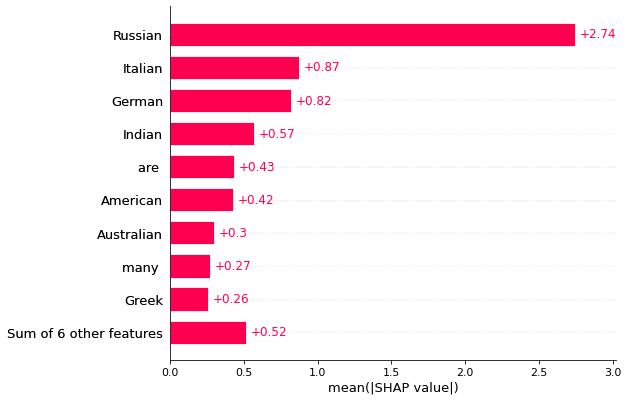

In [19]:
shap.plots.bar(shap_values[...,"vodka"])